In [1]:
import pandas as pd
import numpy as np
from xray_stats import load_process as lp

## Local Statistics
**Summary:** This Jupyter notebook introduces some statistical techniques used to capture soil heterogeneity. In particular, while we've so far looked at basic stats about the distribution of densities/pixel intensity by horizontal x-ray slice, we will now look at more local properties. We will focus on three primary properties: **sliding-window skewness, sliding-window kurtosis and sobel edges**.

### Sliding window statistics (skewness and kurtosis)
These two metrics describe the shape of the distribution of pixel intensities. **Skewness** describes the asymmetry of the distribution, where negative skew indicates a greater concentration of relatively higher values, and a positive skew indicates more lower values. **Kurtosis** describes the "peakedness" or flatness of the distribution compared to the normal distribution. Specifically, it describes how much of the distribution is in the tails. A positive kurtosis results in a more narrow peak while also having heavier tails (more outliers), while a negative value indicates a flatter peak and lighter tails.

For these metrics, rather than calculating skewness and kurtosis on the distribution of all the pixels in the soil core region of a horizontal slice (which can wash out interesting local aspects), we use a sliding window, or a smaller localized subset of pixels, collecting multiple skewness and kurtosis measurments for a single horizontal slice. For a given horizontal slice (just using the soil core region), we can then measure the average, median, standard deviation and percentile values for each metric.

### Sobel Edges
This is an image convolution that calculates the vertical and horizontal gradients of 3x3 window surrounding a pixel and calculates the magnitude. This is used for quantifying edges in an image. We can similarly calculate statistical values for this metric for a given soil core region of a horizontal slice.

**See below for a visualization of these metrics (we also calculate sliding window variance, although the above three metrics seem to be the most informative in distinguishing soils by treatment).**

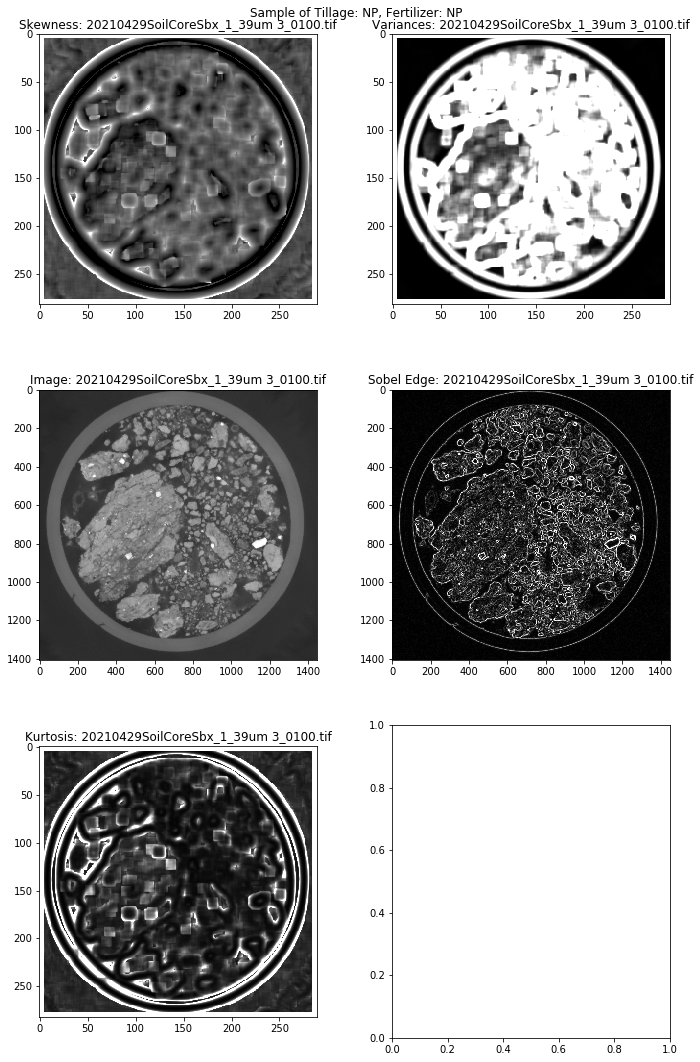

In [2]:
tiff_index = 100 # Index of horizontal slice within an xray scan (higher index is deeper soil)
stack_index = 1 # This xray scan index is between 1 and 54 corresponding to "Sample ID" in the meta.csv.
window_size = 50 # horizontal and vertical size of sliding window (mainly for kurt, skew and variance. Sobel is always 3x3 window convultion)
skip = 5 # how many pixels to skip in both x and y during collection of sliding window metrics.
denoise = True # We use total variation denoising technique (chambolle), see load_process library, wavelet denoising can be used too with some modification.
show_progress = True

skews, kurts, varis = lp.visualize_sliding_window_statistics(tiff_index,stack_index,window_size,skip,denoise,show_progress)


### Kurt vs Skew 
**To get an intuition of how high and low values of both kurt and skew affect what the local sliding window looks like, experiment with the following two cells.**

In this first cell, we produce an interactive plot highlighting regions (in binary) that have different combinations of extreme values of skewness and kurtosis. **You may need to experiment also with different stacks and tiffs (above) to find these extreme combinations.** After running the below cell, hover your cursor over one of the highlighted quadrants to find coordinates that exemplify that quadrant (in white).

Then, input those coordinates in "x" and "y" in the next cell and run the cell to see that sliding window along with a histogram of those pixel values.


In [8]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Calculate high and low kurtosis and skewness
low_kurt = np.percentile(np.array(kurts[~np.isnan(kurts)]), 45)
high_kurt = np.percentile(np.array(kurts[~np.isnan(kurts)]), 95)
low_skew = np.percentile(np.array(skews[~np.isnan(skews)]), 25)
high_skew = np.percentile(np.array(skews[~np.isnan(skews)]), 85)

# Create the subplots with tighter spacing
fig = sp.make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(f"Low kurtosis ({low_kurt:.2f}), Low skew ({low_skew:.2f})", 
                    f"Low kurtosis ({low_kurt:.2f}), High skew ({high_skew:.2f})", 
                    f"High kurtosis ({high_kurt:.2f}), Low skew ({low_skew:.2f})", 
                    f"High kurtosis ({high_kurt:.2f}), High skew ({high_skew:.2f})"),
    vertical_spacing=0.1,  # Adjust vertical spacing
    horizontal_spacing=0.1,  # Adjust horizontal spacing
)

# Add heatmap traces to the subplots
fig.add_trace(go.Heatmap(z=((abs(kurts) < 0.2) & (abs(skews) < 0.2)).astype(int), colorscale='gray', showscale=False), row=1, col=1)
fig.add_trace(go.Heatmap(z=((kurts < low_kurt) & (skews > high_skew)).astype(int), colorscale='gray', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=((kurts > high_kurt) & (skews < low_skew)).astype(int), colorscale='gray', showscale=False), row=2, col=1)
fig.add_trace(go.Heatmap(z=((kurts > high_kurt) & (skews > high_skew)).astype(int), colorscale='gray', showscale=False), row=2, col=2)

# Update layout
fig.update_layout(height=800, width=800, title="Kurtosis and Skewness")

# Show the figure
fig.show()

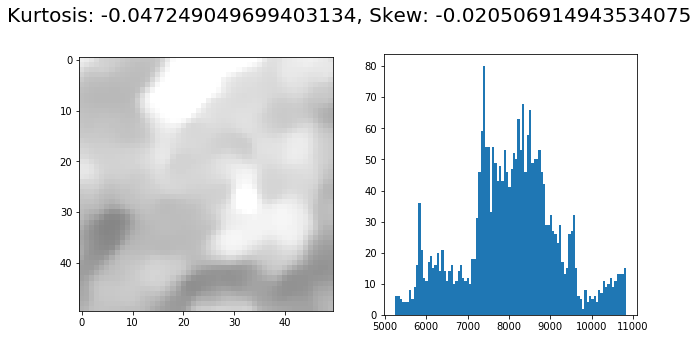

In [11]:
# Input the coordinates you want to see here:
dx = 66*skip
dy = 192*skip

# Then display the sliding window and corresponding pixel value histogram
lp.display_window_with_histogram(tiff_index,stack_index,window_size,denoise,dx,dy) 

In the next notebook, we will be calculating these statistics (as well as per depth coarse soil core statistics) for all 54 datasets.